In [14]:
import torch
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
import random

# 시드 고정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# 데이터 준비
boston_dataset = fetch_openml(name="boston")
X = boston_dataset.data.astype({"CHAS": "float", "RAD": "float"})
# X = X.drop(columns=["CHAS"])
y = boston_dataset.target

# train test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
# train validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED
)

# tensor로 변경
X_train_ts = torch.FloatTensor(X_train.values)
y_train_ts = torch.FloatTensor(y_train.values).unsqueeze(1)

X_val_ts = torch.FloatTensor(X_val.values)
y_val_ts = torch.FloatTensor(y_val.values).unsqueeze(1)

X_test_ts = torch.FloatTensor(X_test.values)
y_test_ts = torch.FloatTensor(y_test.values).unsqueeze(1)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"X_train shape: {X_train_ts.shape}, y_train shape: {y_train_ts.shape}")
print(f"X_val shape: {X_val_ts.shape}, y_val shape: {y_val_ts.shape}")
print(f"X_test shape: {X_test_ts.shape}, y_test shape: {y_test_ts.shape}")


X shape: (506, 13), y shape: (506,)
X_train shape: torch.Size([363, 13]), y_train shape: torch.Size([363, 1])
X_val shape: torch.Size([41, 13]), y_val shape: torch.Size([41, 1])
X_test shape: torch.Size([102, 13]), y_test shape: torch.Size([102, 1])


c:\Users\user\miniconda3\envs\deeplearning\Lib\site-packages\sklearn\datasets\_openml.py:323: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=531
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=853

  warn(warning_msg)


In [15]:
# 모델 생성
class BostonNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(13, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

boston_net = BostonNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
boston_net = boston_net.to(device)  # 모델을 GPU로 이동

# 데이터도 GPU로 이동
X_train_ts = X_train_ts.to(device)
y_train_ts = y_train_ts.to(device)
X_test_ts = X_test_ts.to(device)
y_test_ts = y_test_ts.to(device)
X_val_ts = X_val_ts.to(device)
y_val_ts = y_val_ts.to(device)

# 디바이스 확인
# 사용 가능한 GPU 개수 확인
print(f"사용 가능한 GPU 개수: {torch.cuda.device_count()}")

# 각 GPU 이름 확인
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

print(f"모델이 위치한 디바이스: {next(boston_net.parameters()).device}")


사용 가능한 GPU 개수: 1
GPU 0: NVIDIA GeForce RTX 4070 Laptop GPU
모델이 위치한 디바이스: cuda:0


In [16]:
epochs = 20000
batch_size = 64
batch_num = X_train_ts.shape[0] // batch_size
# val_batch_num = max(X_val_ts.shape[0] // batch_size, 1)

criterion = nn.MSELoss()
optimizer = optim.Adam(boston_net.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5000, 14000], gamma=0.5)  # 학습률 스케쥴러

loss_history = {
    "train": [],
    "validation": []
}


In [17]:


for epoch in range(epochs):
    # train
    boston_net.train()
    loss_tmp = []
    for i in range(batch_num):
        start = i * batch_size
        end = start + batch_size
        # X_batch = X_train_ts[start:end].to(device)
        # y_batch = y_train_ts[start:end].to(device)
        X_batch = X_train_ts[start:end]
        y_batch = y_train_ts[start:end]
        
        optimizer.zero_grad()  # 최적화 함수 초기화
        # yhat = boston_net.forward(X_batch)  # 예측값 계산
        yhat = boston_net(X_batch)  # 예측값 계산
        loss = criterion(yhat, y_batch)  # 손실율 계산
        loss.backward()  # 역전파
        optimizer.step()  # 최적화 함수로 파라미터 업데이트
        loss_tmp.append(loss.item())
    
    loss_mean = sum(loss_tmp) / len(loss_tmp)
    loss_history["train"].append(loss_mean)  # loss
    
    # validation
    boston_net.eval()
    # val_loss_tmp = []
    # with torch.no_grad():
    #     for i in range(val_batch_num):
    #         start = i * batch_size
    #         end = start + batch_size
    #         # X_batch = X_val_ts[start:end].to(device)
    #         # y_batch = y_val_ts[start:end].to(device)
    #         X_batch = X_val_ts[start:end]
    #         y_batch = y_val_ts[start:end]
    #         y_val_pred = model(X_batch)
    #         val_loss = criterion(y_val_pred, y_batch)
    #         val_loss_tmp.append(val_loss.item())
    
    # val_loss_mean = sum(val_loss_tmp) / len(val_loss_tmp)
    # loss_history["validation"].append(val_loss_mean)  # validation loss
    with torch.no_grad():
        # y_val_pred = boston_net.forward(X_val_ts)
        y_val_pred = boston_net(X_val_ts)
        val_loss = criterion(y_val_pred, y_val_ts)
    loss_history["validation"].append(val_loss.item())
    
    # learning curve 출력
    if epoch % 1000 == 0:
        # print(f"Epoch: {epoch}, Train Loss: {loss_mean:.4f}, Validation Loss: {val_loss_mean:.4f}")
        print(f"Epoch: {epoch}, Train Loss: {loss_mean:.4f}, Validation Loss: {val_loss:.4f}")
    
    scheduler.step()  # 학습률 스케줄링 적용
    


Epoch: 0, Train Loss: 583.7510, Validation Loss: 468.2379
Epoch: 1000, Train Loss: 51.6532, Validation Loss: 25.3788
Epoch: 2000, Train Loss: 30.4277, Validation Loss: 14.5643
Epoch: 3000, Train Loss: 22.3746, Validation Loss: 12.8603
Epoch: 4000, Train Loss: 18.0589, Validation Loss: 12.5521
Epoch: 5000, Train Loss: 15.1541, Validation Loss: 12.7989
Epoch: 6000, Train Loss: 14.0564, Validation Loss: 12.4530
Epoch: 7000, Train Loss: 13.0579, Validation Loss: 12.8284
Epoch: 8000, Train Loss: 12.1404, Validation Loss: 11.4090
Epoch: 9000, Train Loss: 11.4479, Validation Loss: 11.1273
Epoch: 10000, Train Loss: 10.7680, Validation Loss: 10.6833
Epoch: 11000, Train Loss: 10.1121, Validation Loss: 10.2821
Epoch: 12000, Train Loss: 9.6533, Validation Loss: 10.0336
Epoch: 13000, Train Loss: 9.2423, Validation Loss: 9.7686
Epoch: 14000, Train Loss: 8.8615, Validation Loss: 9.7985
Epoch: 15000, Train Loss: 8.6849, Validation Loss: 9.8459
Epoch: 16000, Train Loss: 8.5154, Validation Loss: 9.8672


<Figure size 600x400 with 0 Axes>

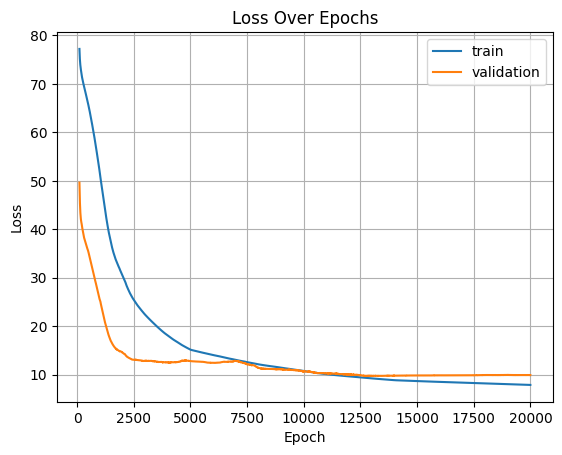

In [18]:
# 학습 곡선 시각화
plt.figure(figsize=(6, 4))

# Train Loss와 Validation Loss 각각 그리기
loss_data = pd.DataFrame(loss_history)
loss_data[100:].plot()

# 그래프 제목 및 라벨 설정
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()  # 그리드 추가
plt.show()


In [19]:
# 테스트 평가
boston_net.eval()

with torch.no_grad():
    # y_test_pred = boston_net.forward(X_test_ts)
    y_test_pred = boston_net(X_test_ts)
    MSE = criterion(y_test_pred, y_test_ts).item()
    
print(MSE)

13.037286758422852
